In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('train_users_2.csv')
se = pd.read_csv('sessions.csv')

In [2]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# Data Exploration and Visualization

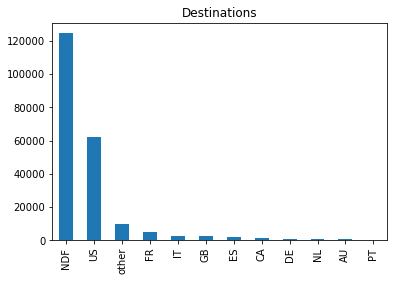

In [2]:
#==============================================================================================
# country_destination
#==============================================================================================
df.country_destination.value_counts().plot(kind='bar')
cindex = df.country_destination.value_counts().index
plt.title('Destinations')

- Most users have not made booking yet
- The most popular destination is US

## Time series & trends

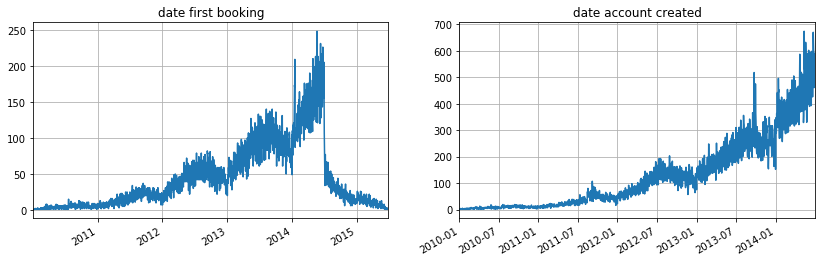

In [3]:
#==============================================================================================
# date_account_created and date_first_booking
#==============================================================================================
# date_account_created
dac_counts = df.date_account_created.value_counts()
dac_counts.index = pd.to_datetime(dac_counts.index)
dac_counts = dac_counts.sort_index()
# date_first_booking
dfb_counts = df.date_first_booking.value_counts()
dfb_counts.index = pd.to_datetime(dfb_counts.index)
dfb_counts = dfb_counts.sort_index()

plt.figure(figsize=(14,4))
plt.subplot(121)
dfb_counts.plot()
plt.title('date first booking')
plt.grid()
plt.subplot(122)
dac_counts.plot()
plt.title('date account created')
plt.grid()

- Number of users are increasing exponentially

### Remove trend for date first booking and apply a low-pass filter

C:\Users\dinsoson\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app


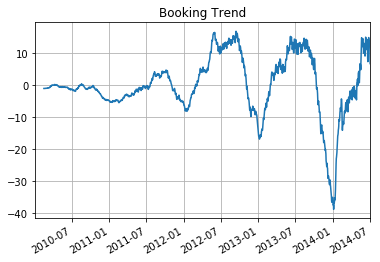

In [5]:
#==============================================================================================
# Remove trend and filter date first booking
#==============================================================================================
ts = dfb_counts.loc[:'2014-07-03']
# Exponential fit
from scipy.optimize import curve_fit
def fexp(t,a,b):
    return a*np.exp(b*t)-1
popt, pcov = curve_fit(fexp, range(len(ts)), ts.values,   p0=(4, .01))
# Remove trend
ts[:] = ts-fexp(np.arange(len(ts)), *popt)
from scipy.signal import detrend
ts[:] = detrend(ts)
# Low-pass filter
ts = pd.rolling_mean(ts,30)

ts.plot()
plt.title('Booking Trend')
plt.grid()

- More users make booking in the summer

### Booking days in a week

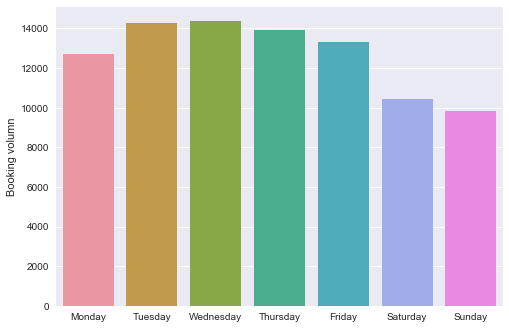

In [24]:
import seaborn as sns
bookdays = pd.DataFrame(pd.to_datetime(df.date_first_booking).dt.weekday_name.value_counts())
bookdays = bookdays.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
bookdays = bookdays.reset_index()
bookdays.columns=['Weekday','Booking']
sns.barplot(x='Weekday', y='Booking', data=bookdays)
plt.ylabel('Booking volumn')
plt.xlabel('')

- More bookings on Tuesday and Wednesday
- Fewer bookings on weekends

## Destination by account age

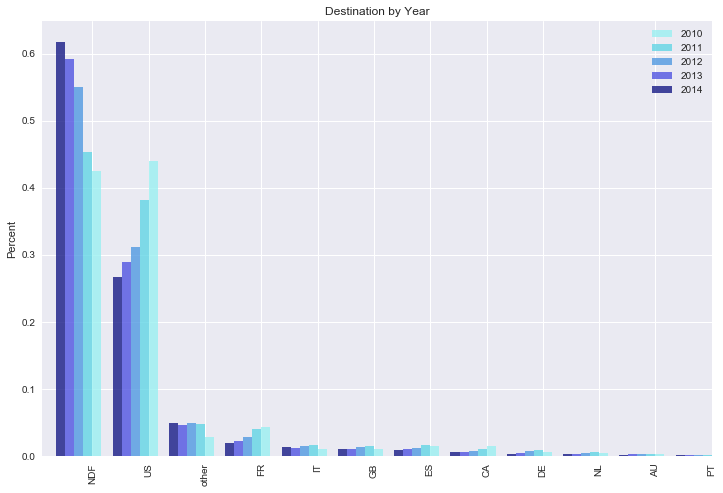

In [8]:
#==============================================================================================
# Percentage of each country each year
#==============================================================================================
y = df.date_account_created.map(lambda x: x[0:4])
y10 = sum(y == '2010')
y11 = sum(y == '2011')
y12 = sum(y == '2012')
y13 = sum(y == '2013')
y14 = sum(y == '2014')
destination10 = df.loc[y == '2010', 'country_destination'].value_counts()/y10
destination10 = destination10.reindex(cindex)
destination11 = df.loc[y == '2011', 'country_destination'].value_counts()/y11
destination11 = destination11.reindex(cindex)
destination12 = df.loc[y == '2012', 'country_destination'].value_counts()/y12
destination12 = destination12.reindex(cindex)
destination13 = df.loc[y == '2013', 'country_destination'].value_counts()/y13
destination13 = destination13.reindex(cindex)
destination14 = df.loc[y == '2014', 'country_destination'].value_counts()/y14
destination14 = destination14.reindex(cindex)
plt.figure(figsize=(12,8))
destination10.plot(kind='bar',color='#9AF0F1',position=0,label='2010',width=.16, alpha=0.8)
destination11.plot(kind='bar',color='#62D5E5',position=1,label='2011',width=.16, alpha=0.8)
destination12.plot(kind='bar',color='#5099E1',position=2,label='2012',width=.16, alpha=0.8)
destination13.plot(kind='bar',color='#5054E1',position=3,label='2013',width=.16, alpha=0.8)
destination14.plot(kind='bar',color='#171A86',position=4,label='2014',width=.16, alpha=0.8)
plt.legend()
plt.ylabel('Percent')
plt.title('Destination by Year')

- Older accounts are more likely to book
- Increasing trend in booking other country

## Gender

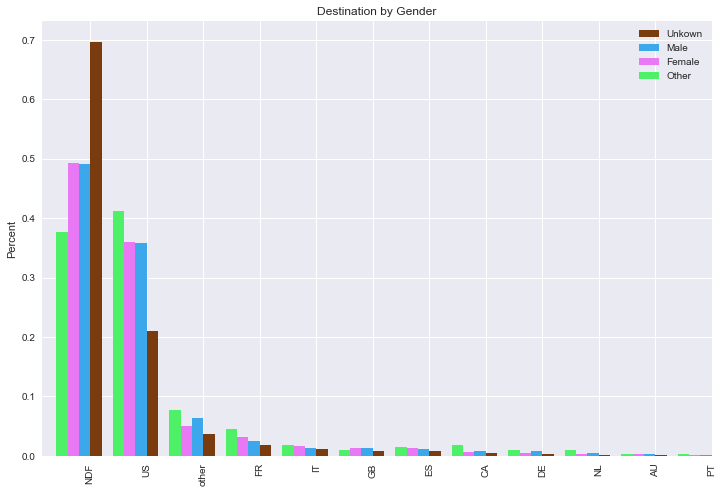

In [9]:
#==============================================================================================
# Gender
#==============================================================================================
genderU = sum(df.gender=='-unknown-')
genderM = sum(df.gender=='MALE')
genderF = sum(df.gender=='FEMALE')
genderO = sum(df.gender=='OTHER')
destinationU = df.loc[df.gender == '-unknown-', 'country_destination'].value_counts()/genderU
destinationU = destinationU.reindex(cindex)
destinationM = df.loc[df.gender == 'MALE', 'country_destination'].value_counts()/genderM
destinationM = destinationM.reindex(cindex)
destinationF = df.loc[df.gender == 'FEMALE', 'country_destination'].value_counts()/genderF
destinationF = destinationF.reindex(cindex)
destinationO = df.loc[df.gender == 'OTHER', 'country_destination'].value_counts()/genderO
destinationO = destinationO.reindex(cindex)

plt.figure(figsize=(12,8))
destinationU.plot(kind='bar',color='#7A3C0F',position=0,label='Unkown',width=.2)
destinationM.plot(kind='bar',color='#3DA7EC',position=1,label='Male',width=.2)
destinationF.plot(kind='bar',color='#E978F4',position=2,label='Female',width=.2)
destinationO.plot(kind='bar',color='#4DF066',position=3,label='Other',width=.2)
plt.legend()
plt.ylabel('Percent')
plt.title('Destination by Gender')

- Other genders are more likely to book
- Unknown genders are less likely to book
- Men are more willing to book other countries comparing to women

## Age

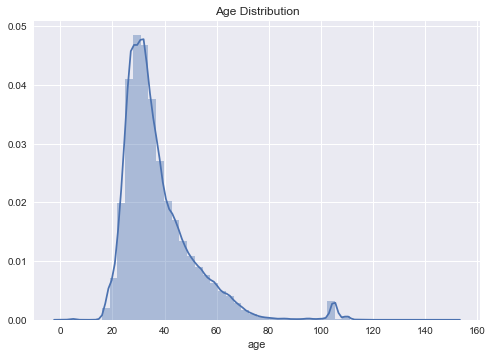

In [10]:
#==============================================================================================
# Age
#==============================================================================================
age = df.age[(df.age < 200)]
sns.distplot(age.dropna())
plt.title('Age Distribution')

- Most users' ages lie between 20-40

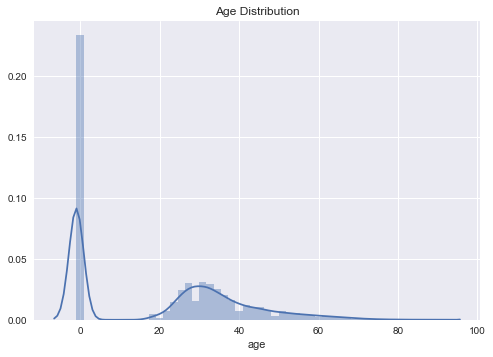

In [11]:
df.loc[df.age <18, 'age'] = -1
df.loc[df.age >90, 'age'] = -1
df.age.fillna(-1,inplace=True)

sns.distplot(df.age.dropna())
plt.title('Age Distribution')

### Real age vs. unknown age

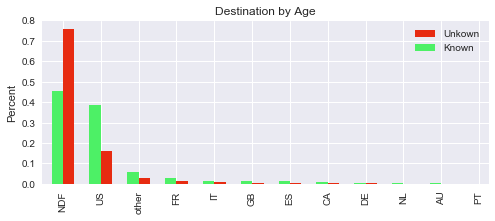

In [12]:
agen = sum(df.age==-1)
agey = sum(df.age!=-1)
destinationn = df.loc[df.age == -1, 'country_destination'].value_counts()/agen
destinationn = destinationn.reindex(cindex)
destinationy = df.loc[df.age != -1, 'country_destination'].value_counts()/agey
destinationy = destinationy.reindex(cindex)

plt.figure(figsize=(8,3))
destinationn.plot(kind='bar',color='#E72B11',position=0,label='Unkown',width=.3)
destinationy.plot(kind='bar',color='#4DF066',position=1,label='Known',width=.3)

plt.legend()
plt.ylabel('Percent')
plt.title('Destination by Age')

- Users with unkown ages are less like to book

### Destination among ages

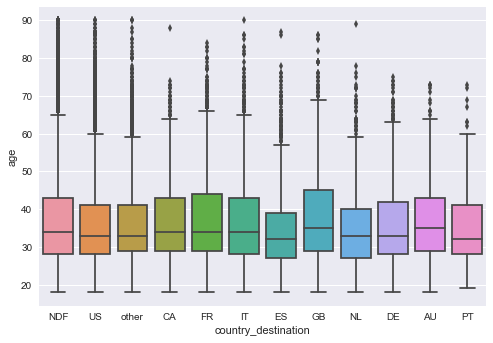

In [13]:
cd_age = df[['age','country_destination']]
sns.boxplot(x='country_destination', y='age', data=cd_age.loc[cd_age.age !=-1])

- Spain is more popular amoung younger users
- UK is more popular amoung older users

## Language

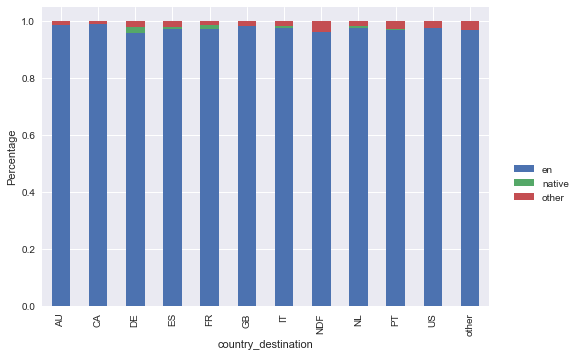

In [16]:
country_language = df['country_destination']
country_language_dict = {'NDF': 'wahaaaaaa', 'US': 'en', 'other': 'wahaaaaaa', 'FR': 'fr', 'IT': 'it', 'GB': 'en', 'ES': 'es', 'CA': 'en', 'DE': 'de', 'NL': 'nl', 'AU': 'en', 'PT': 'pt'}
country_language = country_language.map(country_language_dict)
# Set language into en, native, and other
traveler_language = df.loc[:,'language'].copy()
traveler_language.loc[(df.language!='en') & (df.language==country_language)] = 'native'
traveler_language.loc[(df.language!='en') & (df.language!=country_language)] = 'other'

pd.crosstab(df.country_destination,traveler_language).apply(lambda x: x/x.sum(), axis=1).plot(kind='bar',stacked=True).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Percentage')

- Most users speak English
- People traveling in Germany and France are more likely to be native speakers

## Other features

### Time first active: date and time

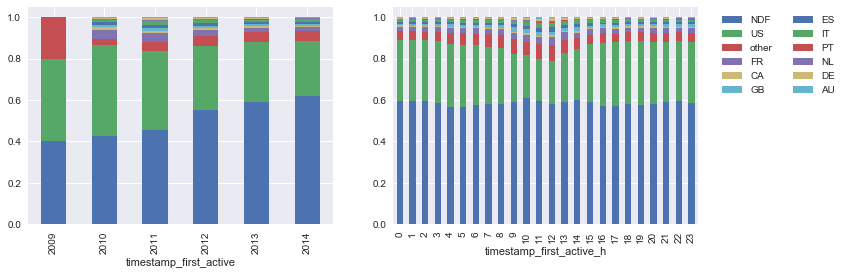

In [18]:
t = df.drop(['id','date_account_created','gender','age','date_first_booking'], axis=1)
t.timestamp_first_active = df.timestamp_first_active.map(lambda x: x/10**10%10000)
t['timestamp_first_active_h'] = df.timestamp_first_active.map(lambda x: x/10**4%100)
ycat = df.country_destination.unique()
xcat = ['timestamp_first_active','timestamp_first_active_h']
cd = t.country_destination
t.drop('country_destination', axis=1, inplace=True)

fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i,cat in enumerate(xcat):
    bars = pd.crosstab(t[cat],cd).apply(lambda x: x/x.sum(), axis=1)
    bars[ycat].plot(kind='bar',stacked=True, legend=False, ax=ax1.reshape(-1)[i])
ax1[1].legend(bbox_to_anchor=(1.05, 1), ncol=2)

- Users with timestamp fisrt active in 2009 are more likely to book other countries
- Less users book the US with timestamp fisrt active on 9am-14am

### Signup methods and devices

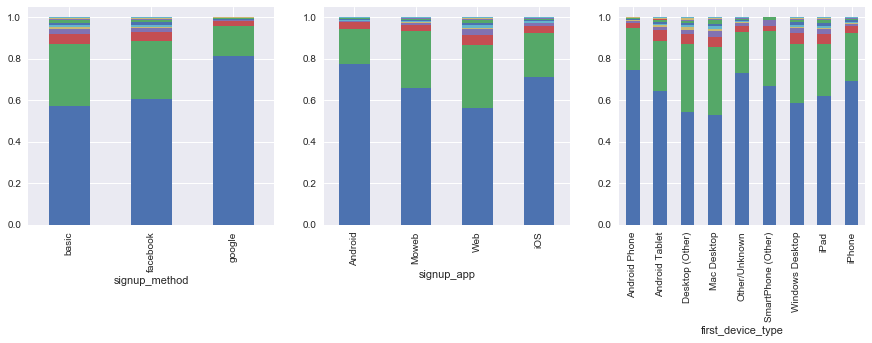

In [19]:
xcat = ['signup_method','signup_app','first_device_type']
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
for i,cat in enumerate(xcat):
    bars = pd.crosstab(t[cat],cd).apply(lambda x: x/x.sum(), axis=1)
    bars[ycat].plot(kind='bar',stacked=True, legend=False, ax=ax2.reshape(-1)[i])

- Users signed up with google are less likely to book
- Users signed up on mobile devices are less likely to book

### Device_type in Session data

In [20]:
se.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


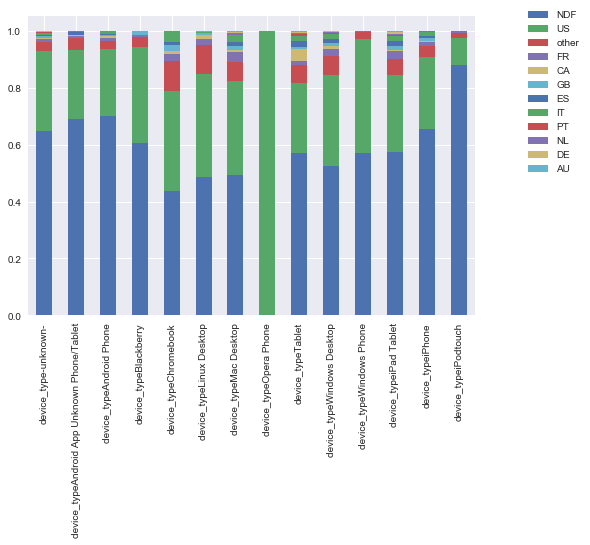

In [21]:
se['c']=1
device_type = pd.pivot_table(se[['user_id','device_type','c']], index='user_id', columns='device_type', values='c', aggfunc=np.sum)
device_type.fillna(0, inplace=True)
device_type = device_type.add_prefix('device_type')

country_device = pd.concat([df.set_index('id').country_destination, device_type], axis=1, join_axes=[df.set_index('id').index])
country_device = pd.pivot_table(country_device, index='country_destination', values=country_device.drop('country_destination',axis=1).columns, aggfunc=np.sum)
country_device.loc[df.country_destination.unique()].transpose().apply(lambda x: x/sum(x), axis=1).plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.1, 1.05))

- People using Chromebooks, Linux Desktops, and Mac Desktops are more likey to book
- There is only one user uses an Opera Phone. She booked the US.

# Feature engineering

In [25]:
#==============================================================================================
# Missing values
#==============================================================================================
for column in df.columns.values:
    print  '{0}: {1}'.format(column, df[column].isnull().sum())

id: 0
date_account_created: 0
timestamp_first_active: 0
date_first_booking: 124543
gender: 0
age: 0
signup_method: 0
signup_flow: 0
language: 0
affiliate_channel: 0
affiliate_provider: 0
first_affiliate_tracked: 6065
signup_app: 0
first_device_type: 0
first_browser: 0
country_destination: 0


- 2.8% of first_affiliate_tracked are missing

In [75]:
df0 = df.copy()
df.set_index('id',inplace=True)
x = df.drop(['date_first_booking','country_destination'],axis=1)
x.first_affiliate_tracked.fillna('null', inplace=True)
y = df.loc[:,'country_destination']

## Split date_account_created and timestamp_first_active into year, month, day, and hour

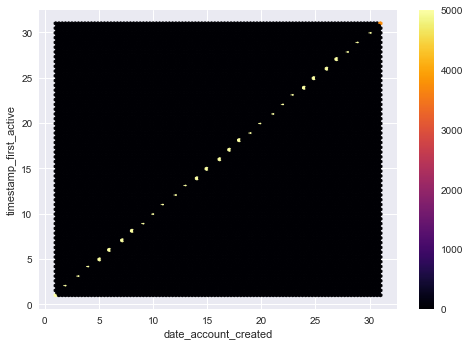

In [63]:
dac = pd.DataFrame(np.vstack(x.date_account_created.map(lambda x: x.split('-')).values), 
                   index=x.index, 
                   columns=['year','month','day'])
tfa = pd.DataFrame(np.vstack((x.timestamp_first_active.astype(str).map(lambda x: [x[0:4],x[4:6],x[6:8],x[8:10]])).values), 
                   index=x.index, 
                   columns=['year','month','day','hour'])
dacx = (dac.iloc[:,2]).astype('int32').values
tfay = (tfa.iloc[:,2]).astype('int32').values
hb = plt.hexbin(dacx,tfay,cmap='inferno')
plt.clim([0,5000])
plt.colorbar(hb)
plt.xlabel('date_account_created')
plt.ylabel('timestamp_first_active')

- Most date_account_created and timestamp_first_active are on the same day

In [76]:
x['dac_year']=dac['year']
x['dac_month']=dac['month']
x['dac_day']=dac['day']
x['tfa_year']=tfa['year']
x['tfa_month']=tfa['month']
x['tfa_day']=tfa['day']
x['tfa_hour']=tfa['hour']
x.drop(['date_account_created'], axis=1, inplace=True)
x.drop(['timestamp_first_active'], axis=1, inplace=True)

## One hot encoding

In [77]:
oh_f = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in oh_f:
    oh = pd.get_dummies(x[f], prefix=f)
    x = pd.concat((x, oh), axis=1)
    x.drop(f, axis=1, inplace=True)

## Session data

### Action counts

In [34]:
se = se.loc[se.user_id.notnull()]
#==============================================================================================
# Counts of each user's action, action_type, action_detail, and device_type
#==============================================================================================
action = pd.pivot_table(se[['user_id','action','c']], index='user_id', columns='action', values='c', aggfunc=np.sum)
action.fillna(0, inplace=True)
action = action.add_prefix('action')

action_type = pd.pivot_table(se[['user_id','action_type','c']], index='user_id', columns='action_type', values='c', aggfunc=np.sum)
action_type.fillna(0, inplace=True)
action_type = action_type.add_prefix('action_type')

action_detail = pd.pivot_table(se[['user_id','action_detail','c']], index='user_id', columns='action_detail', values='c', aggfunc=np.sum)
action_detail.fillna(0, inplace=True)
action_detail = action_detail.add_prefix('action_detail')

device_type = pd.pivot_table(se[['user_id','device_type','c']], index='user_id', columns='device_type', values='c', aggfunc=np.sum)
device_type.fillna(0, inplace=True)
device_type = device_type.add_prefix('device_type')
#==============================================================================================
# Counts of each user's records
#==============================================================================================
uidc = pd.DataFrame(se.user_id.value_counts())
uidc.columns = ['uid_counts']

### Statistics of secs_elapsed

In [54]:
sec_sum = se[['user_id','secs_elapsed']].set_index('user_id').stack().sum(level='user_id')
sec_sum = pd.DataFrame(sec_sum, columns=['sec_sum'])
sec_mean = se[['user_id','secs_elapsed']].set_index('user_id').stack().mean(level='user_id')
sec_mean = pd.DataFrame(sec_mean, columns=['sec_mean'])
sec_std = se[['user_id','secs_elapsed']].set_index('user_id').stack().std(level='user_id')
sec_std = pd.DataFrame(sec_std, columns=['sec_std'])
sec_min = se[['user_id','secs_elapsed']].set_index('user_id').stack().min(level='user_id')
sec_min = pd.DataFrame(sec_min, columns=['sec_min'])
sec_max = se[['user_id','secs_elapsed']].set_index('user_id').stack().max(level='user_id')
sec_max = pd.DataFrame(sec_max, columns=['sec_max'])

### Join features

In [78]:
x = pd.concat([x, 
               action, 
               action_type, 
               action_detail, 
               device_type,
               uidc, 
               sec_sum,
               sec_mean,
               sec_std,
               sec_min,
               sec_max], axis=1, join_axes=[x.index])
x = x.fillna(0)

# Model prediction
## Split training set and test set

In [81]:
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(x, y, test_size=0.1, random_state=7)

## Train models

In [125]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
rf_params = {
    'n_jobs': -1,
    'n_estimators': 40,
    'max_depth': 20,
    'random_state': 7
}
et_params = {
    'n_jobs': -1,
    'n_estimators': 40,
    'max_depth': 20,
    'random_state': 7
}
ada_params = {
    'n_estimators': 40,
    'random_state': 7
}
gb_params = {
    'n_estimators': 4,
    'max_depth': 2,
    'learning_rate': 1,
    'random_state': 7
}
xgb_params = {
    'n_estimators': 4,
    'gamma': 0.5,
    'learning_rate': 0.5,
    'objective': 'binary:logistic',
}

rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
xgb = XGBClassifier(**xgb_params)

## Cross validation

In [114]:
from sklearn.model_selection import cross_val_predict
#==============================================================================================
# NDCG (Normalized discounted cumulative gain)
#==============================================================================================
def dcg5(r):
    return np.sum(r / np.log2(np.arange(2, r.size + 2)))

In [131]:
%%time
p = cross_val_predict(et, xtr, ytr, cv=5, method='predict_proba')

Wall time: 1min 57s


In [177]:
yp = pd.DataFrame(p, index=ytr.index, columns=et.classes_)
destinations = yp.apply(lambda x: pd.Series(x.sort_values(ascending=False)[:5].index.values), axis=1)

In [178]:
destinations.head()

,0,1,2,3,4
id,,,,,
lwbq8p52bp,NDF,US,other,FR,IT
zbgcogxbfp,NDF,US,other,FR,IT
9bcm7nc3vb,NDF,US,other,FR,IT
ycrovav1rf,NDF,US,other,FR,CA
2t0cavmi33,NDF,US,other,FR,IT


In [132]:
relevance = destinations.apply(lambda x: x==ytr.values)
score = relevance.apply(dcg5, axis=1).sum()/relevance.shape[0]
print score

0.819867326702


## Ensemble the 2nd layer
### Out of fold prediction

In [136]:
from sklearn.model_selection import KFold
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(NFOLDS, random_state=7)
def oof(clf, xtrain, ytrain, xtest):
    i=0
    oof_train = np.empty([len(xtrain), len(np.unique(ytrain))])
    oof_test = np.empty([len(xtest), len(np.unique(ytrain))])
    oof_nf = np.empty((NFOLDS, len(xtest), len(np.unique(ytrain))))
    
    for train_index, test_index in kf.split(xtrain):
        xtr = xtrain[train_index]
        ytr = ytrain[train_index]
        xte = xtrain[test_index]

        clf.fit(xtr,ytr)

        oof_train[test_index,0:len(np.unique(ytr))] = clf.predict_proba(xte)
        oof_nf[i,:,0:len(np.unique(ytr))] = clf.predict_proba(xtest)
        i = i+1
        
    oof_test = oof_nf.mean(axis=0)
    return oof_train, oof_test

In [137]:
%%time
country_dict = {'NDF': 0, 'US': 1, 'other': 2, 'FR': 3, 'IT': 4, 'GB': 5, 'ES': 6, 'CA': 7, 'DE': 8, 'NL': 9, 'AU': 10, 'PT': 11}
xx = xtr.values
yy = ytr.map(country_dict).values
xxte = xte.values
oof_rf_tr, oof_rf_te = oof(rf, xx, yy, xxte)
oof_et_tr, oof_et_te = oof(rf, xx, yy, xxte)
oof_ada_tr, oof_ada_te = oof(rf, xx, yy, xxte)
oof_gb_tr, oof_gb_te = oof(rf, xx, yy, xxte)
oof_xgb_tr, oof_xgb_te = oof(rf, xx, yy, xxte)

Wall time: 10min 42s


In [144]:
xtr2 = np.concatenate((oof_rf_tr,oof_et_tr,oof_ada_tr,oof_gb_tr,oof_xgb_tr),axis=1)
xte2 = np.concatenate((oof_rf_te,oof_et_te,oof_ada_te,oof_gb_te,oof_xgb_te),axis=1)

In [149]:
ada_params = {
    'n_estimators': 40,
    'random_state': 7
}
xgb_params = {
    'n_estimators': 4,
    'gamma': 0.5,
    'learning_rate': 0.5,
    'objective': 'binary:logistic',
}

ada2 = AdaBoostClassifier(**ada_params)
xgb2 = XGBClassifier(**xgb_params)

In [151]:
%%time
ada2.fit(xtr2, ytr)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=7)

In [158]:
%%time
xgb2.fit(xtr2, ytr)

Wall time: 15.8 s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.5, learning_rate=0.5, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=4, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Final prediction

In [159]:
pa2 = ada2.predict_proba(xte2)
px2 = xgb2.predict_proba(xte2)

In [172]:
yp = pd.DataFrame((pa2+px2)/2, index=yte.index, columns=ada2.classes_)

In [173]:
destinations = yp.apply(lambda x: pd.Series(x.sort_values(ascending=False)[:5].index.values), axis=1)

In [175]:
relevance = destinations.apply(lambda x: x==yte.values)
score = relevance.apply(dcg5, axis=1).sum()/relevance.shape[0]
score

0.8290693071989671

# Ways to improve the model

### - More low-bias models on the 1st layer
### - Data imputaion for Age and first_affiliate_tracked
### - Dimension reduction